## Import Library

In [1]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import *
import highspy

## Define the parameters using data from excel file

In [2]:
# Load data from Excel file
df = load_workbook('data.xlsx')

# Read specific sheets
theta = df["theta"]
bus_stop_link = df["F_ab"]
destination_location = df["Data_Wisata"]

# Create parameters from data
# Create a list of bus stops and destinations
number_of_locations = 14+1
number_of_bus_stops = 20+1

bus_stops = [theta.cell(row=1, column=j).value for j in range(2, number_of_bus_stops+1)]
locations = [theta.cell(row=i, column=1).value for i in range(2, number_of_locations+1)]

# Create lists of subsets locations
subset_locations_A = locations.copy()
subset_locations_A.remove(locations[0])

subset_locations_B = locations.copy()
subset_locations_B.remove(locations[-1])

subset_locations_C = locations.copy()
subset_locations_C.remove(locations[0])
subset_locations_C.remove(locations[-1])

# Create list of thetas value (value of linking destination and bus stops)
theta_values = [[theta.cell(row=i, column=j).value for j in range (2, number_of_bus_stops+1)] for i in range(2, number_of_locations+1)]
theta_edges = []

for i in range(len(locations)):
    for j in range(len(bus_stops)):
        if theta_values[i][j] == 1:
            theta_edges.append((locations[i], bus_stops[j]))

# Create list of F_ab value (value of linking bus stops)
# , bus stop edges
# and road time
F_bus_stop_values = [[bus_stop_link.cell(row=i, column=j).value for j in range (2, number_of_bus_stops+1)] for i in range(2, number_of_bus_stops+1)]
bus_stops_time = [[df["time_t"].cell(row=i, column=j).value for j in range (2, number_of_bus_stops+1)] for i in range(2, number_of_bus_stops+1)]
bus_stops_edges = []

for i in range(len(bus_stops)):
    for j in range(len(bus_stops)):
        if F_bus_stop_values[i][j] == 1:
            bus_stops_edges.append((bus_stops[i], bus_stops[j], bus_stops_time[i][j]))

# Create lists of destination parameters value
rating_values = [destination_location.cell(row=i, column=2).value for i in range(2, number_of_locations+1)]
distance_values = [[df["distance_d"].cell(row=i, column=j).value for j in range (2, number_of_locations+1)] for i in range(2, number_of_locations+1)]
visit_duration_values = [destination_location.cell(row=i, column=5).value for i in range(2, number_of_locations+1)]
opening_time_values = [destination_location.cell(row=i, column=3).value for i in range(2, number_of_locations+1)]
closing_time_values = [destination_location.cell(row=i, column=4).value for i in range(2, number_of_locations+1)]
minimum_cost_in_location = [destination_location.cell(row=i, column=6).value for i in range(2, number_of_locations+1)]
latitude_loc = [destination_location.cell(row=i, column=7).value for i in range(2, number_of_locations+1)]
longitude_loc = [destination_location.cell(row=i, column=8).value for i in range(2, number_of_locations+1)]

large_number = 10000

In [3]:
# Convert time values to minutes
import datetime

def convert_time(time, offset):
  raw_minutes = time.hour * 60 + time.minute

  if raw_minutes < offset:
    shifted_minutes = 0
  else:
    shifted_minutes = raw_minutes - offset
  return shifted_minutes

start_hour = 4
offset_time = start_hour*60
T_start = 7*60-offset_time
T_max = T_start + 812

time_windows = []

for i in range(len(opening_time_values)):
  time_windows.append((convert_time(opening_time_values[i], offset_time), convert_time(closing_time_values[i], offset_time)))

In [4]:
# Convert zero values in bus stops time matrix to large number
for i in range(len(bus_stops_time)):
    for j in range(len(bus_stops_time)):
        if bus_stops_time[i][j] == 0:
            bus_stops_time[i][j] = 1000

for i in range(len(bus_stops_time)):
    for j in range(len(bus_stops_time)):
        if bus_stops_time[i][j] < 1000:
            bus_stops_time[i][j] += 5

# Convert distance values to time travel values
# Assume average speed is 30 km/h
# and setting if distance less than 1 km, the time travel is 10 minutes
average_speed = 30 # km/h
setup_time = 5 # minutes (waiting time for transportation)

# Initialize array
travel_time_values = [[0 for _ in range(len(distance_values))] for _ in range(len(distance_values))]

for a in range(len(distance_values)):
    for b in range(len(distance_values)):
        dist = float(distance_values[a][b])

        if dist > 0:
            # Calculate pure travel time
            pure_travel_time = (dist / average_speed) * 60

            # Add setup time to each travel
            travel_time_values[a][b] = pure_travel_time + setup_time
        else:
            travel_time_values[a][b] = 0

In [5]:
# Create a function to calculate cost of transportation
def cost_transportation(distance):
  minimum_cost = 11000 # Minimum cost in Indonesian Rupiah
  min_threshold_distance = 3 # km
  cost_per_km = 2500 # Indonesian Rupiah per km after minimum threshold

  if distance <= 0:
    return 0
  elif distance <= 0.8:
    return 0
  else:
    if distance <= min_threshold_distance:
      return minimum_cost
    else:
      return minimum_cost + (distance - min_threshold_distance) * cost_per_km

# Create a list of cost
cost_D = [[0 for _ in range(len(distance_values))] for _ in range(len(distance_values))] # Cost of ojek transportation

for i in range(len(distance_values)):
  for j in range(len(distance_values)):
    dist = float(distance_values[i][j])

    # Calculate cost
    cost = cost_transportation(dist)
    cost_D[i][j] = round(cost, -2)

# Cost of bus
cost_bus = 3000 # In Indonesian rupiah

# Cost maximum
cost_max = 350000 # In Indonesian rupiah

## Analyze linking of bus stops and linking of locations with bus stops

### Locations-bus stops connections

In [6]:
# Define a graph for locations-bus stops connections
G = nx.Graph()

# Add nodes and edges to the graph
G.add_nodes_from(locations, bipartite=0)
G.add_nodes_from(bus_stops, bipartite=1)
G.add_edges_from(theta_edges)

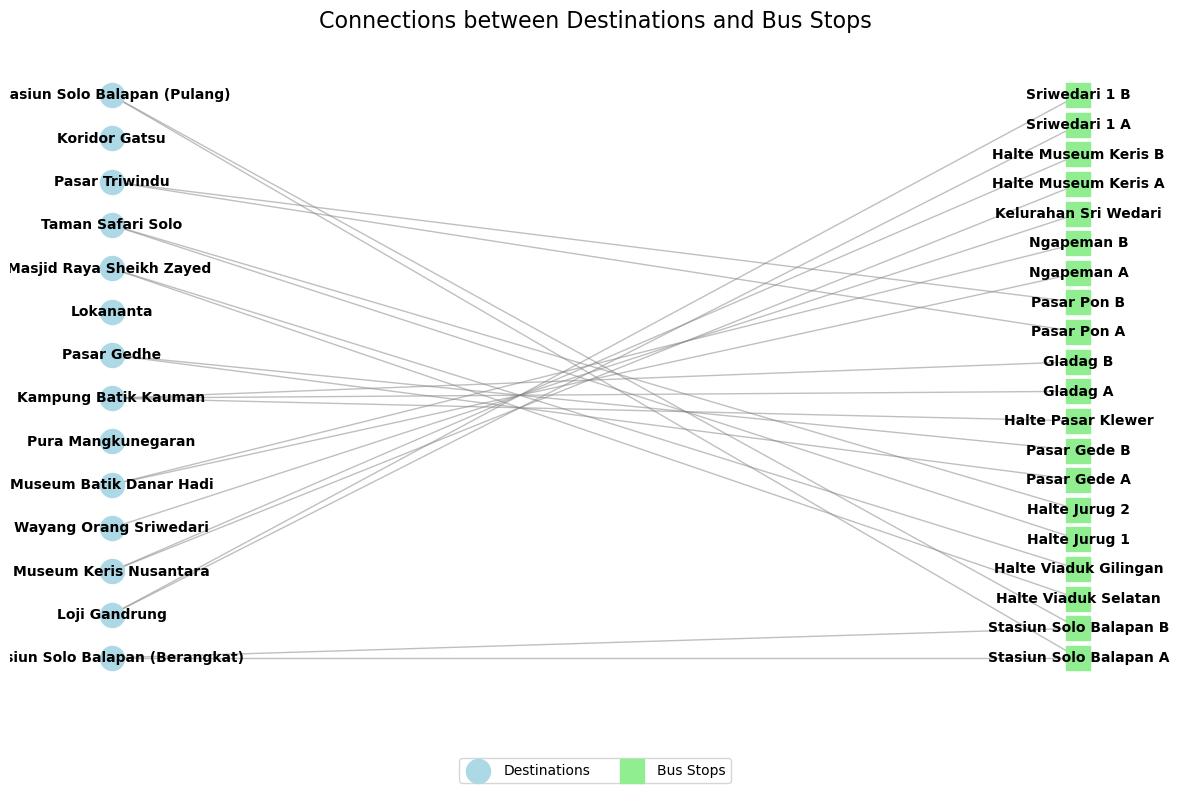

In [7]:
# Visualize the graph
# Define a layout for the graph
pos = nx.bipartite_layout(G, nodes=locations)

# Draw the graph
plt.figure(figsize=(12, 8))

# Visualize nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=locations,
    node_color='lightblue',
    label="Destinations"
)

nx.draw_networkx_nodes(
    G, pos,
    nodelist=bus_stops,
    node_color='lightgreen',
    node_shape='s',
    label="Bus Stops"
)

# Visualize edges
nx.draw_networkx_edges(
    G, pos, edge_color='gray', alpha=0.5
)

# Add labels to nodes
nx.draw_networkx_labels(
    G, pos, font_size=10, font_weight="bold"
)

# Add legend and title
plt.title("Connections between Destinations and Bus Stops", fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.axis('off')
plt.tight_layout()
plt.show()

### Connections of Bus Stops

In [8]:
# Create a graph for bus stops connections
G_bus_stops = nx.DiGraph()

# Add nodes and edges to the graph
G_bus_stops.add_nodes_from(bus_stops)
G_bus_stops.add_weighted_edges_from(bus_stops_edges)

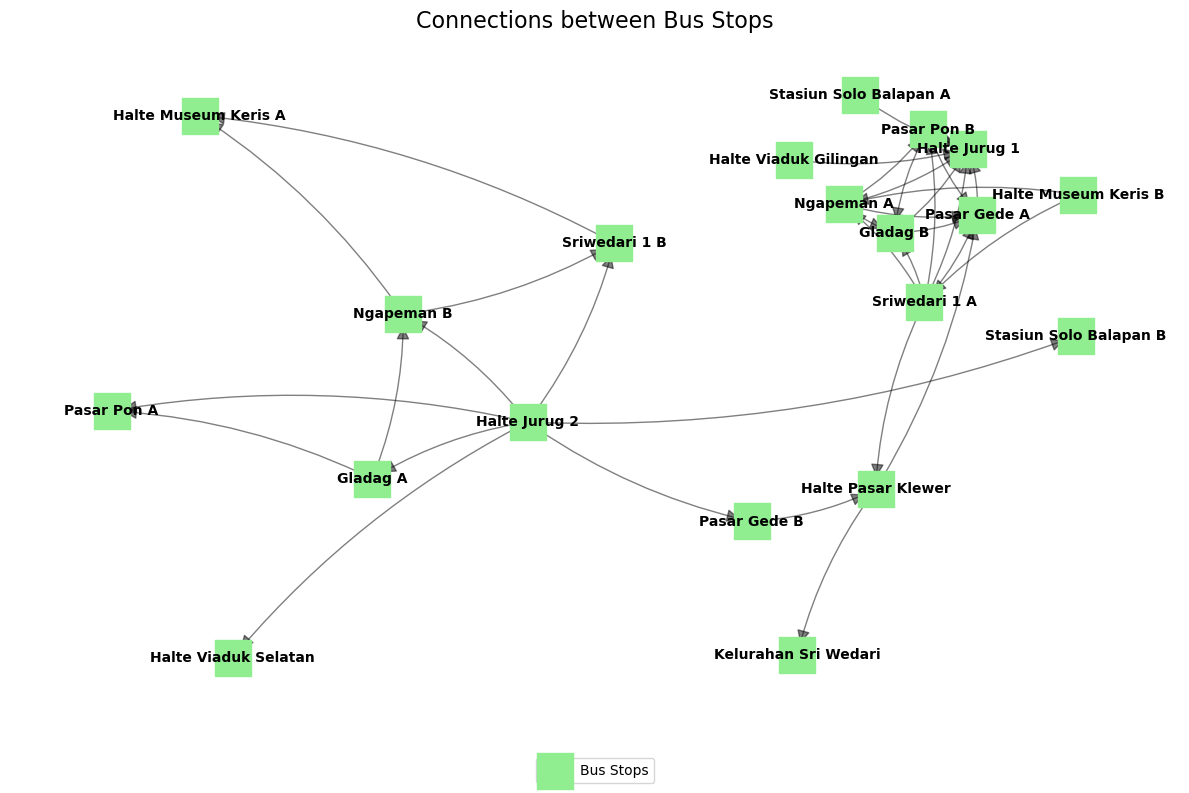

In [9]:
# Visualize the graph
# Define a layout for the graph
pos_bus_stops = nx.spring_layout(G_bus_stops, k=1, iterations=50, seed=42)

# Draw the graph
plt.figure(figsize=(12, 8))

# Visualize nodes
nx.draw_networkx_nodes(
    G_bus_stops,
    pos_bus_stops,
    nodelist=bus_stops,
    node_color='lightgreen',
    node_size=700,
    node_shape='s',
    label="Bus Stops"
)

# Visualize edges
nx.draw_networkx_edges(
    G_bus_stops,
    pos_bus_stops,
    alpha=0.5,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20,
    connectionstyle='arc3, rad=0.1'
)

# Add labels to nodes
nx.draw_networkx_labels(
    G_bus_stops, 
    pos_bus_stops, 
    font_size=10, 
    font_weight="bold"
)

# Add legend and title
plt.title("Connections between Bus Stops", fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.axis('off')
plt.tight_layout()
plt.show()

## Modelling

In [10]:
# Define library
from pulp import *

# Define the problem
starting_location = locations[0]
end_location = locations[-1]
hoi = LpProblem("Holiday Itinerary Problem", LpMaximize)

# Define decision variables
X = LpVariable.dicts("X", (locations, locations), cat="Binary")
Y = LpVariable.dicts("Y", (bus_stops, bus_stops), cat="Binary")
Z = LpVariable.dicts("Z", (locations), cat="Binary")
tau = LpVariable.dicts("tau", (locations), lowBound=0, cat="Continuous")
u = LpVariable.dicts("u", (locations), lowBound=0, upBound=len(locations), cat="Integer")

# Objective function: Maximize total rating of visited destinations
hoi += (
    lpSum([rating_values[idx]*Z[node_name] for idx, node_name in enumerate(subset_locations_C)])
)

# Define Constraints
# Constraint 1: Starting and ending at specific locations
hoi += (
    lpSum([X[starting_location][node_name] for node_name in subset_locations_A]) +
    lpSum([
        Y[a][b]*theta_values[locations.index(starting_location)][idx_a]*theta_values[idx_j+1][idx_b]
        for idx_a, a in enumerate(bus_stops)
        for idx_b, b in enumerate(bus_stops)
        for idx_j, j in enumerate(subset_locations_A)
        if a != b
    ]) == 1
)

hoi += (
    lpSum([X[i][end_location] for i in subset_locations_C]) +
    lpSum([
        Y[c][a]*theta_values[locations.index(end_location)][idx_a]*theta_values[idx_i+1][idx_c]
        for idx_a, a in enumerate(bus_stops)
        for idx_c, c in enumerate(bus_stops)
        for idx_i, i in enumerate(subset_locations_C)
        if c != a
    ]) == 1
)

# Constraint 2 : Flow conservation at each location
for idx_j, j in enumerate(subset_locations_C):
  hoi += (
      lpSum([X[i][j] for i in subset_locations_B if i != j]) +
      lpSum([
          Y[a][b]*theta_values[idx_i][idx_a]*theta_values[idx_j+1][idx_b]
          for idx_a, a in enumerate(bus_stops)
          for idx_b, b in enumerate(bus_stops)
          for idx_i, i in enumerate(subset_locations_B)
          if a != b
          if i != j
      ]) == Z[j]
  )

for idx_i, i in enumerate(subset_locations_C):
  hoi += (
      lpSum([X[i][j] for j in subset_locations_A if i != j]) +
      lpSum([
          Y[a][b]*theta_values[idx_i+1][idx_a]*theta_values[idx_j+1][idx_b]
          for idx_a, a in enumerate(bus_stops)
          for idx_b, b in enumerate(bus_stops)
          for idx_j, j in enumerate(subset_locations_A)
          if a != b
          if i != j
      ]) == Z[i]
  )

for i in locations:
  hoi += (
      Z[i] <= 1
  )

# Constraint 3 : Subtour elimination
for idx_i, i in enumerate(subset_locations_A):
  for idx_j, j in enumerate(subset_locations_A):
    if i != j:
      hoi += (
          u[i] - u[j] + 1 <= (len(locations) - 1)*(1 - (X[i][j] + lpSum([Y[a][b]*theta_values[idx_i+1][idx_a]*theta_values[idx_j+1][idx_b] for idx_a, a in enumerate(bus_stops) for idx_b, b in enumerate(bus_stops)])))
      )

for i in subset_locations_A:
  hoi += (
      u[i] >= 2
  )

for i in subset_locations_A:
  hoi += (
      u[i] <= len(locations)
  )

hoi += (
    u[starting_location] == 1
)

# Constraint 4 : Time window and visit duration
for idx_i, i in enumerate(locations):
  for idx_j, j in enumerate(locations):
    if i != j:
      hoi += (
          tau[i] + travel_time_values[idx_i][idx_j]*X[i][j] +
          lpSum([
              bus_stops_time[idx_a][idx_b]*Y[a][b]*theta_values[idx_i][idx_a]*theta_values[idx_j][idx_b]
              for idx_a, a in enumerate(bus_stops)
              for idx_b, b in enumerate(bus_stops)
              if a != b
          ]) +
          visit_duration_values[idx_i] - tau[j] <=
          large_number*(1 - (X[i][j] + lpSum([
              Y[a][b]*theta_values[idx_i][idx_a]*theta_values[idx_j][idx_b]
            for idx_a, a in enumerate(bus_stops)
            for idx_b, b in enumerate(bus_stops)
            if a != b
          ])))
      )

for idx_i, i in enumerate(locations):
  hoi += (
      tau[i] >= time_windows[idx_i][0]
  )

for idx_i, i in enumerate(locations):
  hoi += (
      tau[i] <= time_windows[idx_i][1] - visit_duration_values[idx_i]
  )

hoi += (
    tau[starting_location] >= T_start
)

hoi += (
    tau[end_location] <= T_max
)

# Constraint 5 : Bus stop linking constraints
for idx_a, a in enumerate(bus_stops):
  for idx_b, b in enumerate(bus_stops):
    if a != b:
      hoi += (
          Y[a][b] <= F_bus_stop_values[idx_a][idx_b]
      )

# Constraint 6 : Maximum time constraint
hoi += (
    lpSum([travel_time_values[idx_i][idx_j]*X[i][j] for idx_i, i in enumerate(locations) for idx_j, j in enumerate(locations) if i != j]) +
    lpSum([
              bus_stops_time[idx_a][idx_b]*Y[a][b]*theta_values[idx_i][idx_a]*theta_values[idx_j][idx_b]
              for idx_a, a in enumerate(bus_stops)
              for idx_b, b in enumerate(bus_stops)
              for idx_i, i in enumerate(locations)
              for idx_j, j in enumerate(locations)
              if a != b
              if i != j
          ]) +
    lpSum([visit_duration_values[idx_i]*Z[i] for idx_i, i in enumerate(locations)]) <= T_max
)

# Constraint 7 : Maximum cost constraint
hoi += (
    lpSum([cost_D[idx_i][idx_j]*X[i][j] for idx_i, i in enumerate(locations) for idx_j, j in enumerate(locations) if i != j]) +
    lpSum([
        cost_bus*Y[a][b]*theta_values[idx_i][idx_a]*theta_values[idx_j][idx_b]
        for idx_a, a in enumerate(bus_stops)
        for idx_b, b in enumerate(bus_stops)
        for idx_i, i in enumerate(locations)
        for idx_j, j in enumerate(locations)
        if a != b
        if i != j
    ]) +
    lpSum([minimum_cost_in_location[idx_i]*Z[i] for idx_i, i in enumerate(locations)]) <= cost_max
)

c:\Users\banus\miniconda3\envs\env_optimisasi\lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


## Solve Model

In [11]:
# Solve the model
solver = HiGHS()
hoi.solve(solver)

1

In [12]:
# Check the status of the solution
print(f"Solution status: {LpStatus[hoi.status]}")

# If Optimal, read the results
if LpStatus[hoi.status] == 'Optimal':
    print("Solution found!")
    print(f"Total Score (Objective Value): {value(hoi.objective)}")
else:
    print("Solution not found or Infeasible.")

Solution status: Optimal
Solution found!
Total Score (Objective Value): 50.7


## Visualize Solution

In [13]:
# Define the graph for the solution
hoi_graf = nx.DiGraph()

# Define nodes
for i, var in Z.items():
  if var.varValue is not None and var.varValue > 0.9:
    hoi_graf.add_node(i, tipe="location")

halte_active = set()

for a in Y:
  for b in Y[a]:
    var_y = Y[a][b]

    if var_y.varValue is not None and var_y.varValue > 0.9:
      hoi_graf.add_node(a, tipe="bus_stop")
      hoi_graf.add_node(b, tipe="bus_stop")

      halte_active.add(a)
      halte_active.add(b)

      hoi_graf.add_edge(a, b, tipe="bus")

# Define edges
for i_node in X:
    for j_node in X[i_node]:
        var = X[i_node][j_node]
        if var.varValue is not None and var.varValue > 0.9:
            hoi_graf.add_edge(i_node, j_node)

for location in Z:
  if Z[location].varValue > 0.9:
    # Find all haltes connected to the current location
    connected_haltes = [edge[1] for edge in theta_edges if edge[0] == location]

    # Add 'walk' edges if the connected halte is active
    for bus_stop_name in connected_haltes:
      if bus_stop_name in halte_active:
        hoi_graf.add_edge(location, bus_stop_name, tipe="walk")

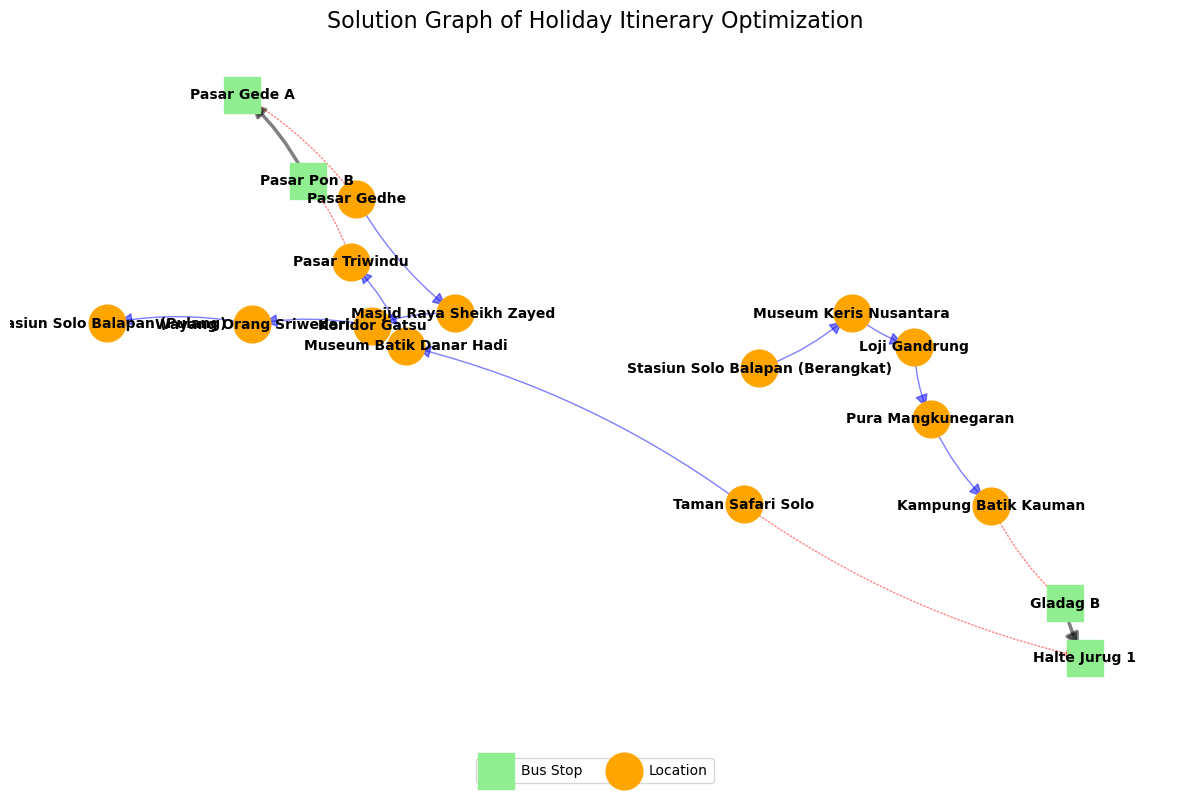

In [14]:
# Visualize the solution graph
pos_hoi_graf = nx.spring_layout(hoi_graf, seed=123)
plt.figure(figsize=(12,8))

location_node = [n for n, attr in hoi_graf.nodes(data=True) if attr.get('tipe') != 'bus_stop']
bus_stop_node = [n for n, attr in hoi_graf.nodes(data=True) if attr.get('tipe') == 'bus_stop']

# Memvisualisasikan node Halte
nx.draw_networkx_nodes(
    hoi_graf,
    pos_hoi_graf,
    nodelist=bus_stop_node,
    node_color='lightgreen',
    node_size=700,
    node_shape='s',
    label="Bus Stop"
)

nx.draw_networkx_nodes(
    hoi_graf,
    pos_hoi_graf,
    nodelist=location_node,
    node_color='orange',
    node_size=700,
    label="Location"
)

# Memvisualisasikan Edges
edge_non_bus = [(u, v) for u, v, attr in hoi_graf.edges(data=True) if attr.get('tipe') is None]
edge_bus = [(u, v) for u, v, attr in hoi_graf.edges(data=True) if attr.get('tipe') == 'bus']
edge_walk = [(u, v) for u, v, attr in hoi_graf.edges(data=True) if attr.get('tipe') == 'walk']

nx.draw_networkx_edges(
    hoi_graf,
    pos_hoi_graf,
    edgelist=edge_non_bus,
    edge_color='blue',
    width=1,
    alpha=0.5,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20,
    connectionstyle='arc3, rad=0.1'
)

nx.draw_networkx_edges(
    hoi_graf,
    pos_hoi_graf,
    edgelist=edge_bus,
    edge_color='black',
    width=2.5,
    alpha=0.5,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20,
    connectionstyle='arc3, rad=0.1'
)

nx.draw_networkx_edges(
    hoi_graf,
    pos_hoi_graf,
    edgelist=edge_walk,
    edge_color='red',
    alpha=0.5,
    connectionstyle='arc3, rad=0.1',
    style='dotted'
)

# Label
nx.draw_networkx_labels(hoi_graf, pos_hoi_graf, font_size=10, font_weight="bold")

# Legends
plt.title("Solution Graph of Holiday Itinerary Optimization", fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.axis('off')
plt.tight_layout()
plt.show()